# CS289 Grad Project: Police Records Access Project Database

In [1]:
%cd ../..

/Users/milanliessens/Documents/Education/Universities/Berkeley/MEng/Fall 2025/CS 289 - ML/Grad Project


In [93]:
%load_ext autoreload
%autoreload 2


import torch
import pathlib
import os
import pytesseract

import pandas as pd
import numpy as np

from pdf2image import convert_from_path
from tqdm import tqdm
from PIL import Image, ImageDraw
from PIL.PpmImagePlugin import PpmImageFile
from dataclasses import dataclass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Downloading the data from the online database

In [ ]:
from src.io.download import scrape_database
scrape_database(start_page=1, end_page=1)

/Users/milanliessens/Documents/Education/Universities/Berkeley/MEng/Fall 2025/CS 289 - ML/Grad Project
KQED Police Records Downloader

Output directory: data/policerecords/pdfs
starting id at 364
Initializing Chrome driver...

Starting download from pages 1 to 1
Output directory: /Users/milanliessens/Documents/Education/Universities/Berkeley/MEng/Fall 2025/CS 289 - ML/Grad Project/data/policerecords/pdfs


Processing Page 1

Fetching page 1: https://policerecords.kqed.org/?page=1
Waiting for content to load...

Browser closed.


KeyboardInterrupt: 

## Structuring the Database

In [186]:
@dataclass
class Page:
    text: str
    ocr_data: pd.DataFrame
    image: PpmImageFile

    def __str__(self):
        return self.text

    def __len__(self):
        return len(self.text)

    def draw_boxes(self):
        coordinates = self.ocr_data[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box
            actual_boxes.append(actual_box)

        image = self.image.copy()
        draw = ImageDraw.Draw(image, "RGB")
        for box in actual_boxes:
            draw.rectangle(box, outline='red')
        return image

@dataclass
class Document:
    name: str
    format: str
    location: Path
    pages: list[Page]

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.name

    def describe(self):
        return {"name": self.name, "format": self.format}

    def get_full_content(self):
        pass

    def __len__(self):
        pass

    def set_tokens(self, tokens):
        pass

    def get_tokens(self):
        return []

    def inspect(self,pagenr=0):
        assert pagenr < len(self.pages)
        return self.pages[pagenr].draw_boxes()

    def read(self):
        content = ''
        for page in self.pages:
            content += page.text
        print(content)


## Reading the data

### Utils

In [81]:
from src.config import DATA_DIR

def concatenate(s):
    return ' '.join([str(t) for t in s if str(t) != 'nan' and str(t).strip() != ''])

def get_text(ocr_data, show=False):
    lines = ocr_data.groupby(
        ['page_num','block_num','line_num'])[['text']].agg(concatenate)
    text = str('\n'.join(lines['text'].values))
    if show:
       print(text)
    return text

def get_file_id(filename):
    return int(filename.split('id')[1].split('.pdf')[0])


### Functions

In [ ]:
def _read_single_pdf_pytesseract(path: Path) -> Document:
    print(f"Reading {path.name} with pytesseract")

    images = convert_from_path(path, first_page=1, last_page=1)
    pages = []

    for image in images[:1]:
        print(f'Processing page {len(pages)+1} / {len(images)}')

        ocr_data = pd.DataFrame(
                pytesseract.image_to_data(
                    image = image,
                    lang = 'eng',
                    output_type=pytesseract.Output.DICT)
                    )
        text = get_text(ocr_data, show=False)
        pages.append(Page(text=text, ocr_data = ocr_data, image = image))

        # image = preprocess(page).unsqueeze(0).to(device)

    print(' --> done')
    return Document(pages = pages, name = path.name, format = 'pdf', location = path)

def read_pdfs(path: Path, method = 'pytesseract', limit = 5):
    count = 0
    pdfs = []
    files = {get_file_id(f.name) : f for f in path.iterdir() if f.is_file() and f.name.endswith('.pdf')}

    if method == 'pytesseract':
        for filenr in range(1,limit+1):
            file = files[filenr]
            pdfs.append(_read_single_pdf_pytesseract(file))
            count += 1
            print(f'reading pdf {count}/{limit}')

            if count == limit:
                break
    else:
        raise ValueError(f"Unknown method {method} for reading PDF")
    return pdfs

In [187]:
documents = read_pdfs(DATA_DIR, method='pytesseract', limit = 1)

Reading page01_case01_document01_id0001.pdf with pytesseract
Processing page 1 / 1
<class 'PIL.PpmImagePlugin.PpmImageFile'>
 --> done
reading pdf 1/1


## Viewing the Data

In [188]:
documents[0].read()





The Police Commission



CITY AND COUNTY OF SAN FRANCISCO CINDY ELIAS
AMENDED 10/1/24 President
SAN FRANCISCO POLICE COMMISSION AGENDA MAX CARTER-OBERSTONE
REGULAR MEETING :
WEDNESDAY, OCTOBER 2, 2024 LARRY YEE
5:30 p.m. ss

CITY HALL, Room 400
#1 Dr. Carlton B. Goodlett Place

San Francisco KEVIN BENEDICTO
Commissioner



WATCH: San Francisco Cable Channel 26



WATCH: www.sfgovtv.org CURA WALKER
(Explanatory and/or Supporting Documents, if any, are posted at: https://sf.gov/meeting/october-2-2024/october-2-2024-police- a
commission-meeting GON AY
With the return to in-person meetings and the end of the City and State’s public emergency orders, there will be no remote public
comment, except for disability accommodations. a
Pledge of Allegiance; Roll Call Sergeant Stacy Youngblood
1. Weekly Officer Recognition Certificate eee
Presentation of an Officer who has gone above and beyond in the performance of their duties.
- Officer Ryan Walsh, Star No. 1967, Northern Station
2. General 

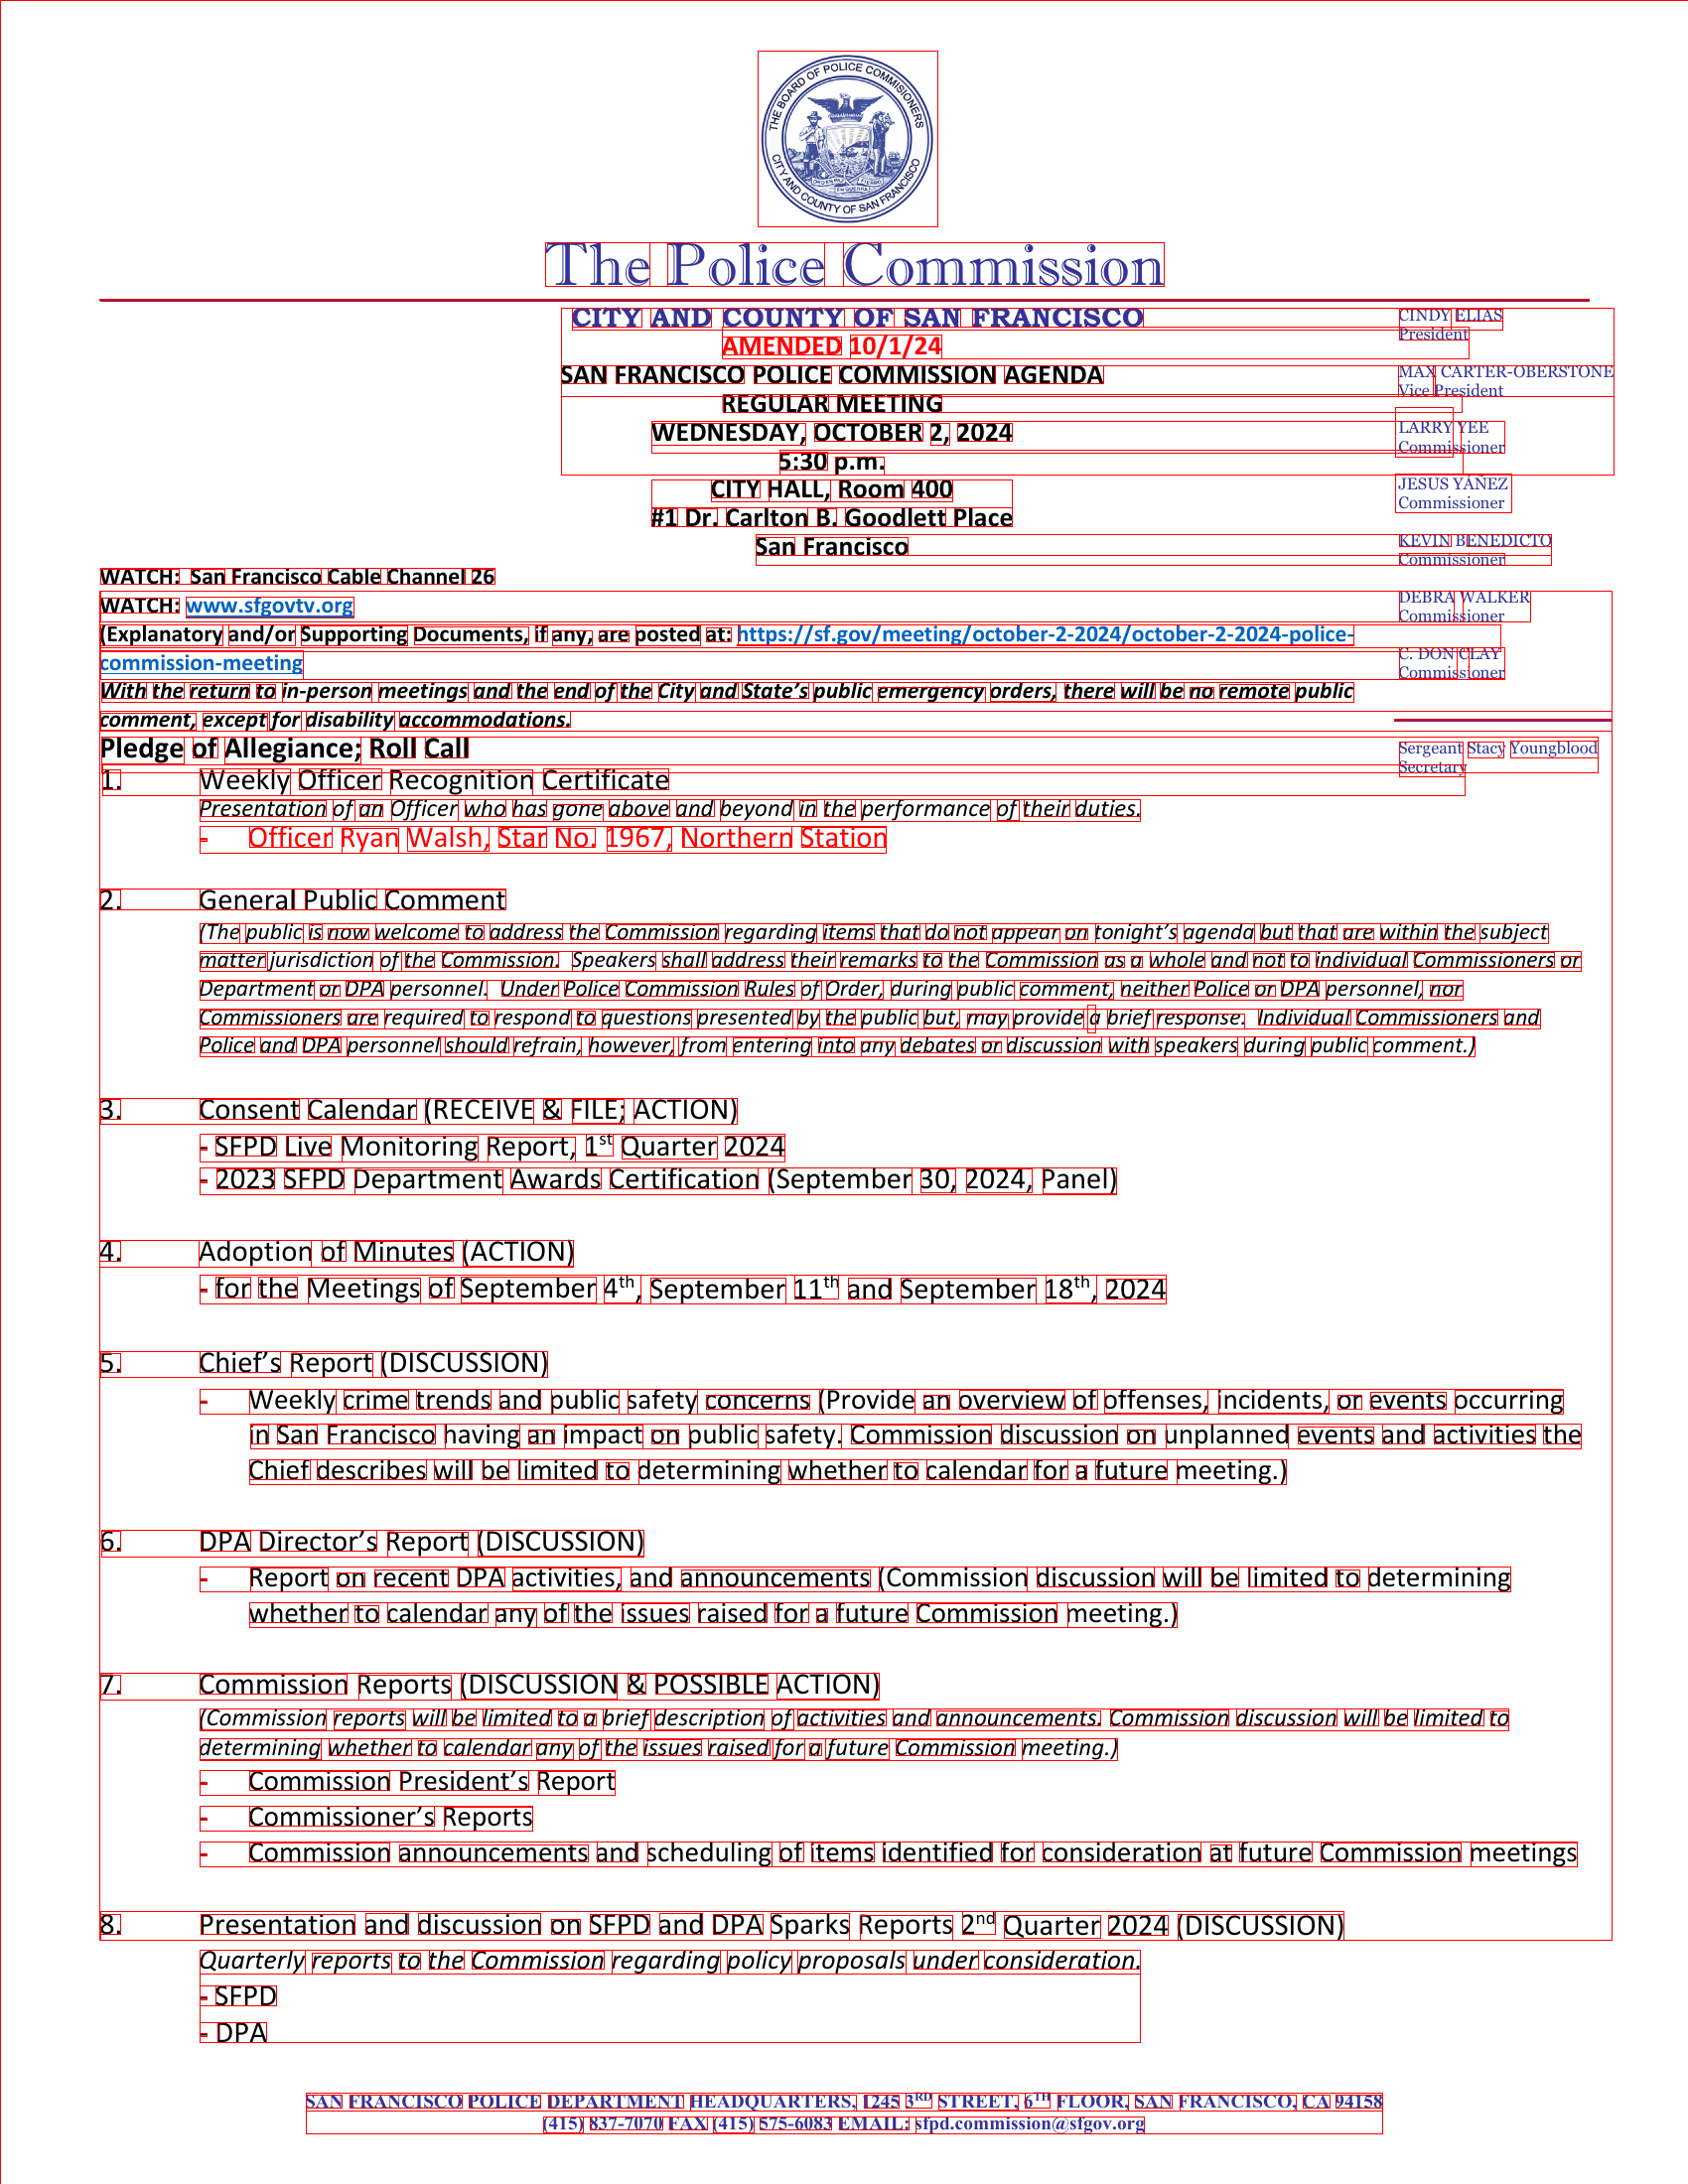

In [189]:
documents[0].inspect()